##### **Name:** Rohan Karthikeyan
##### **Roll number:** MDS202226

In this notebook, we will predict the travel time for buses.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html

# Set some options
pd.set_option('display.max_columns', 50)

## Reading in the data

We start by showing the first few rows of both the train and the evaluation data sets.

In [ ]:
bus_traces = pd.read_parquet('../input/endsem/BMTC.parquet.gzip', engine='pyarrow')
eval_set = pd.read_csv('../input/endsem/Task1_EvalData.csv')

# Bring the Timestamp column to the front
col = bus_traces.pop('Timestamp')
bus_traces.insert(0, col.name, col)

# Display train and test dataframes side by side
df1_styler = bus_traces.head().style.set_table_attributes("style='display:inline'").set_caption('Training data')
df2_styler = eval_set.head().style.set_table_attributes("style='display:inline'").set_caption('Test data')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
print('\nWe have training data for {} unique buses.'.format(bus_traces['BusID'].nunique()))

Training data 
 
 
   
 Timestamp 
 BusID 
 Latitude 
 Longitude 
 Speed 
 
 
 
 
 0 
 2019-08-01 07:00:02 
 150212121 
 13.074558 
 77.445549 
 0.000000 
 
 
 1 
 2019-08-01 07:00:12 
 150212121 
 13.074558 
 77.445549 
 0.000000 
 
 
 2 
 2019-08-01 07:00:22 
 150212121 
 13.074558 
 77.445549 
 0.000000 
 
 
 3 
 2019-08-01 07:00:32 
 150212121 
 13.074558 
 77.445549 
 0.000000 
 
 
 4 
 2019-08-01 07:00:42 
 150212121 
 13.074558 
 77.445549 
 0.000000 
 
 
 

 
 Test data 
 
 
   
 Source_Lat 
 Source_Long 
 Dest_Lat 
 Dest_Long 
 TT 
 
 
 
 
 0 
 12.941644 
 77.557335 
 12.942002 
 77.551605 
 2.833333 
 
 
 1 
 12.845487 
 77.662079 
 12.845881 
 77.667892 
 1.500000 
 
 
 2 
 12.973492 
 77.622871 
 12.957303 
 77.621246 
 21.250000 
 
 
 3 
 12.819298 
 77.688995 
 12.814241 
 77.692986 
 2.000000 
 
 
 4 
 12.973240 
 77.615402 
 13.016170 
 77.627800 
 35.733333


We have training data for 1942 unique buses.


### Goal
The **goal** of the problem is to predict the time a bus will take to travel from one place to another. With this aim, we first notice a discrepancy in the format of the data sets we have been provided:
* The training data has _**real-time information**_ of the GPS coordinates, and the timestamp of the bus' location every 10 secs.
* The test data, on the other hand, only has the _**static**_ source and destination GPS coordinates.

### Conclusion
It is wise to convert the training data into a similar structure as that of the test set.

## Methods
Following the line of some previous research papers on the topic (e.g., [here](https://doi.org/10.3846/transport.2021.15220)), we perform the following steps:
1. Calculate the distance, `Dist`, between consecutive rows in the training data using the [Haversine formula](https://www.movable-type.co.uk/scripts/gis-faq-5.1.html).  
    - Calculate the distance between the source and destination coordinates in the test data as well.
2. Remove rows of each bus' journey where it remains at the same location.
3. Calculate the difference in the timestamps between consecutive rows, `TimeDiff`.
4. Group the data frame by bus ID and add up `Dist` and `TimeDiff`.
5. Now, we have a regression problem to which we can apply a suitable model.

We now start our data processing steps.

### Step 1: Calculate Haversine Distance

In [ ]:
def haversine(lat1, lon1, lat2, lon2, in_radians=False, earth_radius=6371):
    """
    From Stack Overflow 43450530.

    Calculate the great-circle distance between two points on the earth.
    """
    if not in_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [ ]:
# For the training set
bus_traces['Dist'] = haversine(bus_traces['Latitude'], bus_traces['Longitude'],
                               bus_traces['Latitude'].shift(), bus_traces['Longitude'].shift())
# Set distances for the first row of every unique busID to np.nan
uniq_idx = np.unique(bus_traces['BusID'], return_index=True)[1]
bus_traces.loc[bus_traces.index.isin(uniq_idx), 'Dist'] = np.nan

bus_traces

Timestamp      BusID   Latitude  Longitude  Speed      Dist
0       2019-08-01 07:00:02  150212121  13.074558  77.445549    0.0       NaN
1       2019-08-01 07:00:12  150212121  13.074558  77.445549    0.0  0.000000
2       2019-08-01 07:00:22  150212121  13.074558  77.445549    0.0  0.000000
3       2019-08-01 07:00:32  150212121  13.074558  77.445549    0.0  0.000000
4       2019-08-01 07:00:42  150212121  13.074558  77.445549    0.0  0.000000
...                     ...        ...        ...        ...    ...       ...
6014941 2019-08-01 18:59:20  150813395  13.097612  77.565689   30.0  0.082068
6014942 2019-08-01 18:59:30  150813395  13.097538  77.564873   34.0  0.088757
6014943 2019-08-01 18:59:40  150813395  13.097462  77.564049   38.0  0.089640
6014944 2019-08-01 18:59:50  150813395  13.097604  77.563217   21.0  0.091480
6014945 2019-08-01 19:00:00  150813395  13.097601  77.563103    0.0  0.012351

[6014946 rows x 6 columns]

In [ ]:
# For the test set
eval_set['Dist'] = haversine(eval_set['Source_Lat'], eval_set['Source_Long'],
                             eval_set['Dest_Lat'], eval_set['Dest_Long'])
# Swap Dist and TT
eval_set = eval_set[eval_set.columns.to_list()[:4] + ['Dist', 'TT']]
eval_set

Source_Lat  Source_Long   Dest_Lat  Dest_Long       Dist         TT
0      12.941644    77.557335  12.942002  77.551605   0.622237   2.833333
1      12.845487    77.662079  12.845881  77.667892   0.631720   1.500000
2      12.973492    77.622871  12.957303  77.621246   1.808726  21.250000
3      12.819298    77.688995  12.814241  77.692986   0.709538   2.000000
4      12.973240    77.615402  13.016170  77.627800   4.958999  35.733333
...          ...          ...        ...        ...        ...        ...
1200   13.097792    77.591736  13.154475  77.568077   6.803679  27.233333
1201   12.794702    77.624046  12.863790  77.616608   7.724445  26.750000
1202   12.922270    77.743591  12.983501  77.752258   6.873050  53.600000
1203   12.918303    77.589500  12.923568  77.655655   7.193703  59.616667
1204   12.984523    77.600754  13.083735  77.560806  11.850318  59.816667

[1205 rows x 6 columns]

#### Visualization
For a better understanding of the data, we would like to visualize the distance covered by three randomly selected buses:

In [ ]:
import random

idx = random.sample(bus_traces.BusID.tolist(), 3)
small = bus_traces[bus_traces.BusID.isin(idx)]
small = small.reset_index(drop=True)
small

Timestamp      BusID   Latitude  Longitude  Speed      Dist
0    2019-08-01 07:00:02  150218811  12.924046  77.652740   29.0       NaN
1    2019-08-01 07:00:12  150218811  12.923845  77.653656   35.0  0.101759
2    2019-08-01 07:00:23  150218811  12.923700  77.654617   39.0  0.105392
3    2019-08-01 07:00:33  150218811  12.923481  77.655655   38.0  0.115102
4    2019-08-01 07:00:43  150218811  12.923185  77.656639   40.0  0.111608
...                  ...        ...        ...        ...    ...       ...
8279 2019-08-01 18:32:44  150811707  12.855563  77.569740    0.0  0.000000
8280 2019-08-01 18:41:42  150811707  12.855563  77.569740    0.0  0.000000
8281 2019-08-01 18:50:40  150811707  12.855563  77.569740    0.0  0.000000
8282 2019-08-01 18:51:39  150811707  12.855563  77.569740    0.0  0.000000
8283 2019-08-01 18:55:39  150811707  12.855563  77.569740    0.0  0.000000

[8284 rows x 6 columns]

Plotting the `Dist` column would be too noisy, hence we plot the cumulative sum of `Dist`:

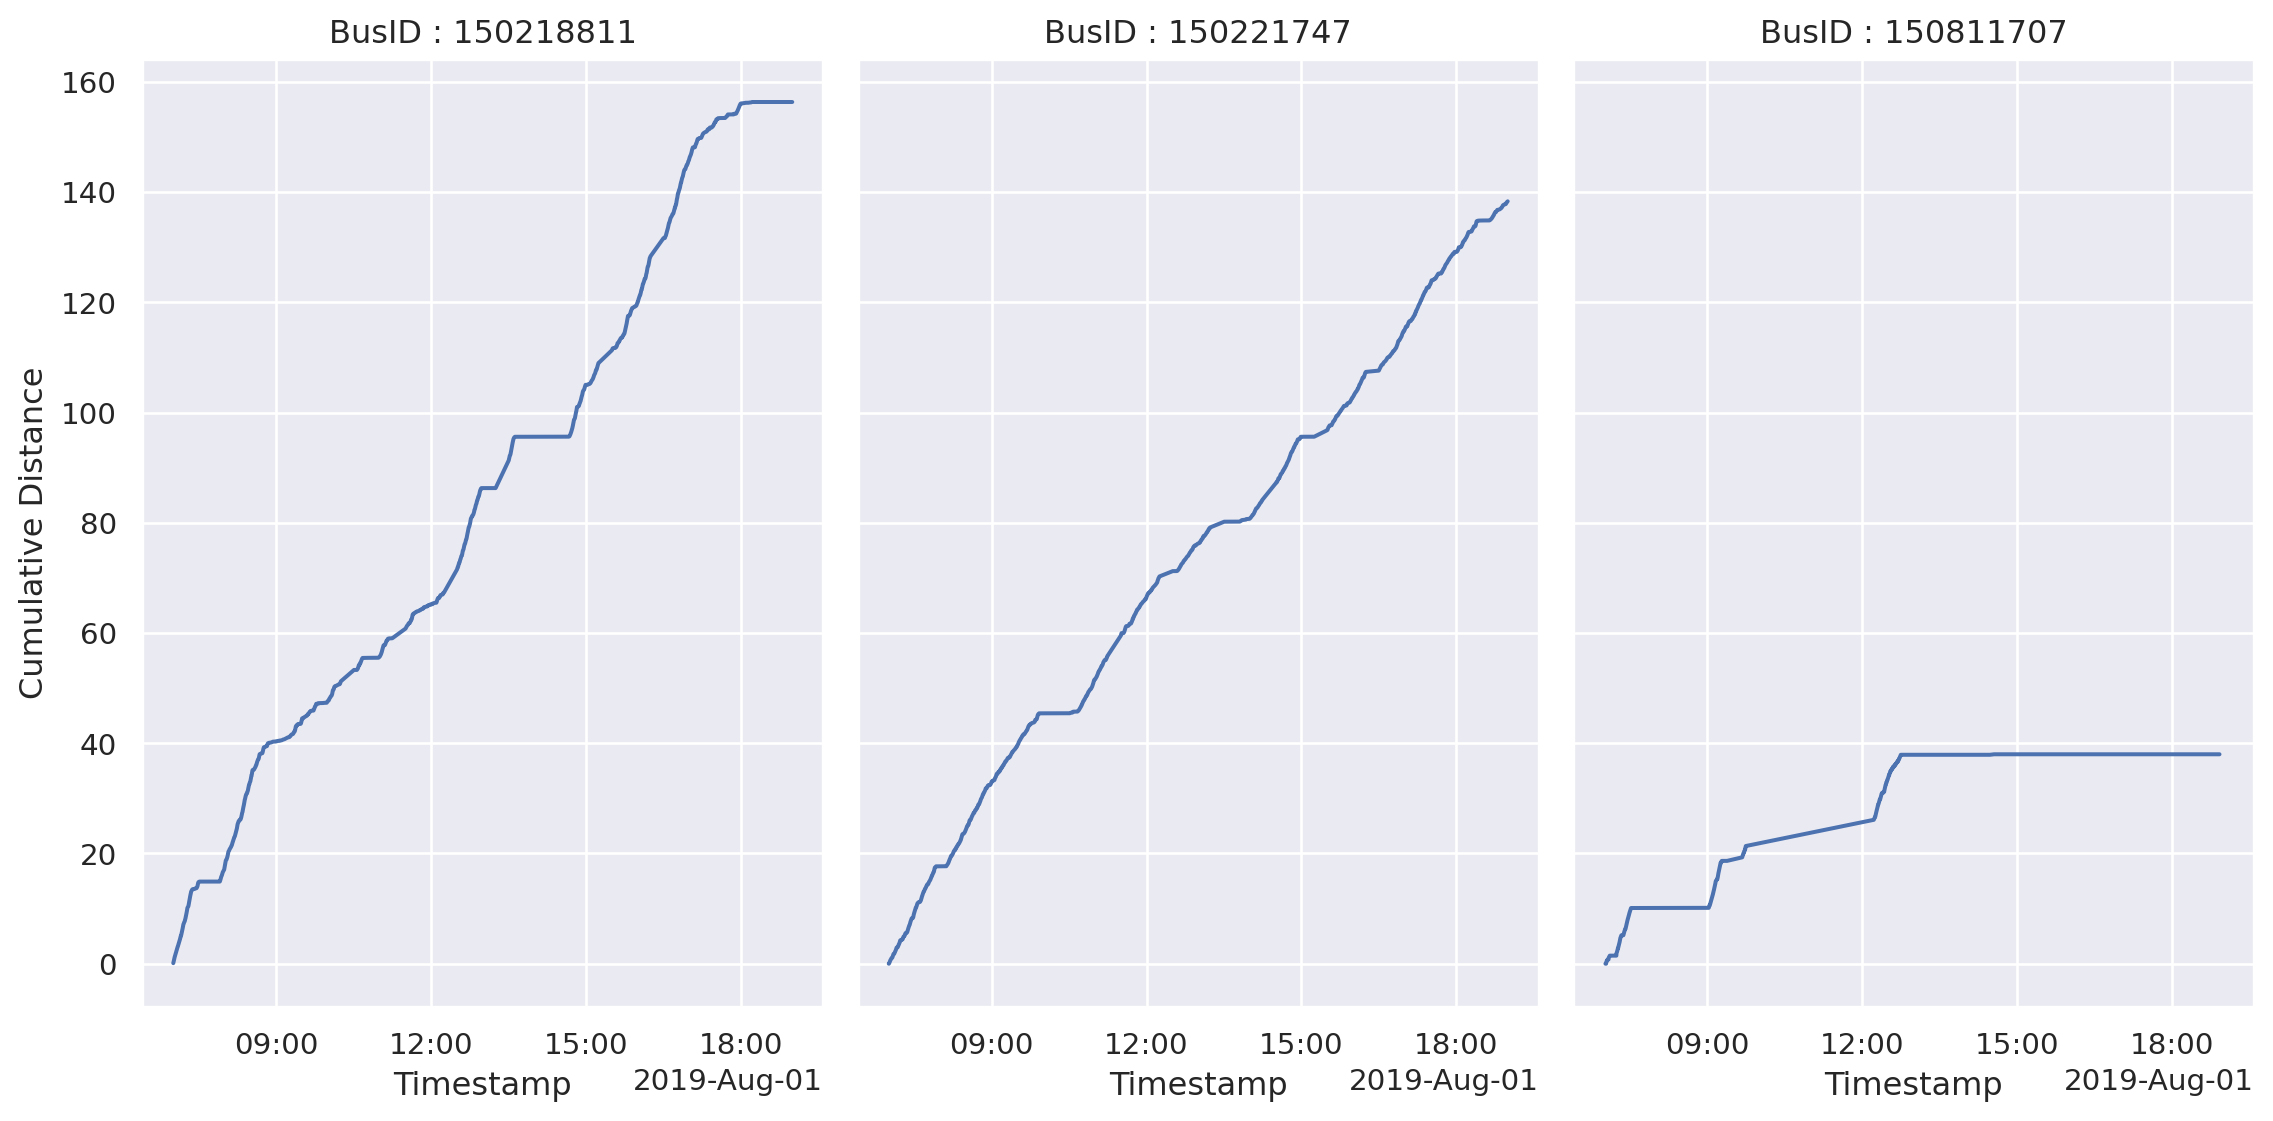

In [ ]:
import seaborn.objects as so

small['CumDist'] = small.groupby(["BusID"]).Dist.cumsum()

p = so.Plot(small, x="Timestamp", y="CumDist").layout(size=(12,6)).add(so.Line())
p.facet('BusID').scale(x=so.Temporal().label(concise=True)).label(
    x = 'Timestamp', y = 'Cumulative Distance', title = 'BusID : {}'.format)

While the second bus steadily covers a good amount of distance over time, we see prolonged stoppages (indicated by a flat line) in both the first plot and the third plot.

### Step 2: Remove rows of each bus' journey where it is not moving
The third plot tells us something important: we should probably not account for the moments when the bus is stationary. This step is important from the perspective of modeling as it will present a distorted picture of reality.

Now, it's important not to remove all duplicates: for instance, the bus may have stopped at a traffic signal in the middle of its journey and hence, it will have the same GPS coordinates between consecutive rows. It would be beneficial to rather drop the consecutive rows if it's repeated at least a certain number of times, say, `thresh`.

We set `thresh` = 7 (equivalent to 1 min 10 secs), which we hope is enough.

In [ ]:
print('The initial number of bus traces was {}.'.format(bus_traces.shape[0]))

# Code snippet adapted from SO 63182136
thresh = 7
s = bus_traces['Dist'].diff().ne(0).cumsum()

new_traces = bus_traces[s.groupby(s).transform('size') < thresh]
new_traces = new_traces.reset_index(drop=True)

print('After processing, we are left with {} rows.\n'.format(new_traces.shape[0]))
new_traces

The initial number of bus traces was 6014946.
After processing, we are left with 4351908 rows.



Timestamp      BusID   Latitude  Longitude  Speed      Dist
0       2019-08-01 07:00:02  150212121  13.074558  77.445549    0.0       NaN
1       2019-08-01 07:25:26  150212121  13.074113  77.445282   21.0  0.057313
2       2019-08-01 07:25:36  150212121  13.074060  77.445267    0.0  0.006113
3       2019-08-01 07:31:04  150212121  13.069714  77.446480   22.0  0.500795
4       2019-08-01 07:31:14  150212121  13.069661  77.446579   14.0  0.012236
...                     ...        ...        ...        ...    ...       ...
4351903 2019-08-01 18:59:20  150813395  13.097612  77.565689   30.0  0.082068
4351904 2019-08-01 18:59:30  150813395  13.097538  77.564873   34.0  0.088757
4351905 2019-08-01 18:59:40  150813395  13.097462  77.564049   38.0  0.089640
4351906 2019-08-01 18:59:50  150813395  13.097604  77.563217   21.0  0.091480
4351907 2019-08-01 19:00:00  150813395  13.097601  77.563103    0.0  0.012351

[4351908 rows x 6 columns]

### Step 3: Calculate time difference between consecutive rows
Now that we have removed problematic rows, we can calculate the time differences for each bus ID. But we need to incorporate the fact that we have dropped rows where the bus was stationary for at least 7 time periods.

If the bus was stationary for 5 hours, then a naive approach would output 5 hours as the value for the "time difference" column, which is not reasonable.
- So, we explictly set that column to 10 seconds if the value is greater than 70 seconds (~ 7 * 10) to signal the start of a new journey.

In [ ]:
new_traces['TimeDiff'] = new_traces.groupby('BusID')['Timestamp'].diff() / pd.Timedelta(minutes=1)
new_traces["TimeDiff"] = np.where(new_traces["TimeDiff"] > 1.16, 1/6, new_traces["TimeDiff"])

new_traces

Timestamp      BusID   Latitude  Longitude  Speed      Dist  \
0       2019-08-01 07:00:02  150212121  13.074558  77.445549    0.0       NaN   
1       2019-08-01 07:25:26  150212121  13.074113  77.445282   21.0  0.057313   
2       2019-08-01 07:25:36  150212121  13.074060  77.445267    0.0  0.006113   
3       2019-08-01 07:31:04  150212121  13.069714  77.446480   22.0  0.500795   
4       2019-08-01 07:31:14  150212121  13.069661  77.446579   14.0  0.012236   
...                     ...        ...        ...        ...    ...       ...   
4351903 2019-08-01 18:59:20  150813395  13.097612  77.565689   30.0  0.082068   
4351904 2019-08-01 18:59:30  150813395  13.097538  77.564873   34.0  0.088757   
4351905 2019-08-01 18:59:40  150813395  13.097462  77.564049   38.0  0.089640   
4351906 2019-08-01 18:59:50  150813395  13.097604  77.563217   21.0  0.091480   
4351907 2019-08-01 19:00:00  150813395  13.097601  77.563103    0.0  0.012351   

         TimeDiff  
0             NaN  
1        0.166667  
2        0.166667  
3        0.166667  
4        0.166667  
...           ...  
4351903  0.166667  
4351904  0.166667  
4351905  0.166667  
4351906  0.166667  
4351907  0.166667  

[4351908 rows x 7 columns]

### Step 4: Calculate the sum of distance traveled and time taken for each bus ID

In [ ]:
X = new_traces.groupby('BusID').agg(
    Distance = ('Dist', 'sum'),
    Time = ('TimeDiff', 'sum')
).reset_index(drop=True)

X

Distance        Time
0     171.526594  365.083333
1     166.720782  428.300000
2     128.971977  316.650000
3     155.407759  532.250000
4     107.825024  583.750000
...          ...         ...
1937  124.505452  567.550000
1938  101.158301  219.950000
1939  151.897110  533.750000
1940   61.239945  137.316667
1941  159.339857  601.550000

[1942 rows x 2 columns]

### Step 5: Building regression models

We first build our train and test splits:

In [ ]:
from sklearn.model_selection import train_test_split

# Split train set into training and validation set
y = X.pop("Time")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=34)

X_test = eval_set.loc[:, 'Dist':].copy()
X_test.columns = ['Distance', 'Time']
y_test = X_test.pop('Time')

#### Model 1: Linear Regression (Ridge)

We start off with a simple ridge regression model:

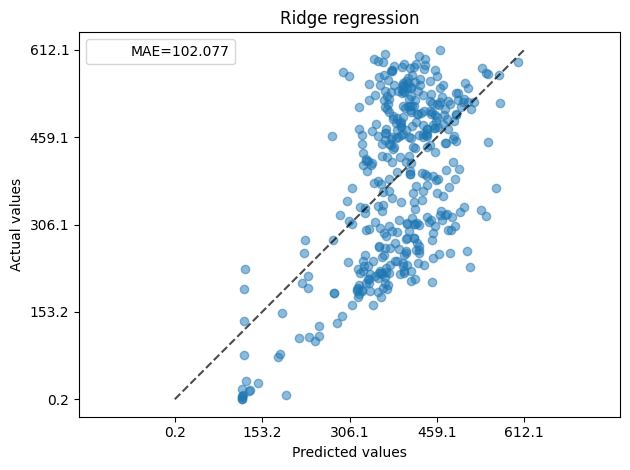

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import PredictionErrorDisplay

ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_valid)

# Plot predicted v/s actual values
f, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(y_valid, y_pred_ridge, kind="actual_vs_predicted",
                                        ax=ax, scatter_kwargs={"alpha": 0.5})

mae = mean_absolute_error(y_valid, y_pred_ridge)
ax.plot([], [], " ", label="MAE={:.3f}".format(mae))
ax.legend(loc="upper left")
ax.set_title("Ridge regression")
plt.tight_layout()

Let us also quantify its performance on the test set.

In [ ]:
y_pred_test = ridge_cv.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print('We have a MAE of {:.3f} on the test set.'.format(mae_test))

We have a MAE of 99.611 on the test set.


#### Model 2: Support Vector Regression
We now try a nu-SVR model, which has been tried out in the literature for solving this problem:

In [ ]:
%%time
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV

svr = GridSearchCV(NuSVR(), scoring = 'neg_mean_absolute_error',
                   param_grid={'kernel': ['linear', 'rbf'], 'C': [1, 2, 5, 10], 'nu': [0.1, 0.3, 0.5]})
svr.fit(X_train, y_train)

print(f"Best nuSVR with params: {svr.best_params_} and MAE: {-svr.best_score_:.3f}")

Best nuSVR with params: {'C': 10, 'kernel': 'rbf', 'nu': 0.5} and MAE: 104.248
CPU times: user 19.3 s, sys: 930 µs, total: 19.3 s
Wall time: 19.3 s


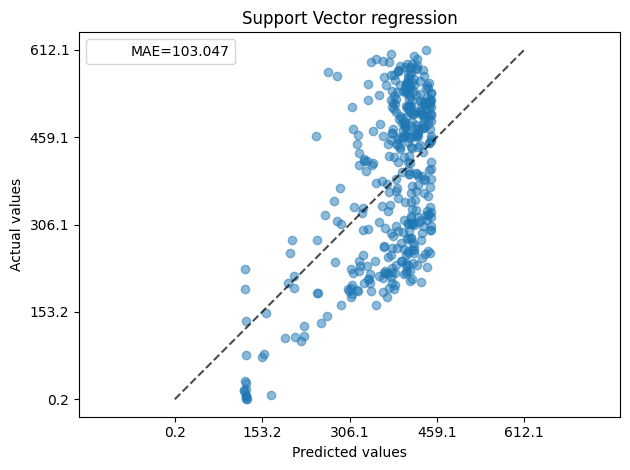

In [ ]:
y_pred_svr = svr.predict(X_valid)

# Plot predicted v/s actual values
f, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(y_valid, y_pred_svr, kind="actual_vs_predicted",
                                        ax=ax, scatter_kwargs={"alpha": 0.5})

mae_svr = mean_absolute_error(y_valid, y_pred_svr)
ax.plot([], [], " ", label="MAE={:.3f}".format(mae_svr))
ax.legend(loc="upper left")
ax.set_title("Support Vector regression")
plt.tight_layout()

In [ ]:
y_pred_test = svr.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print('We have a MAE of {:.3f} on the test set.'.format(mae_test))

We have a MAE of 90.962 on the test set.


As expected, the MAE of nuSVR is lower than that of the Ridge regression model!